## Functions Declaration for Converting Coordinates

In [1]:
from pyproj import Proj, transform # Import necessary functions from pyproj library
import re # Import re module for regular expressions

# Define boundaries for Auckland city
min_lat, max_lat = -37.0, -36.5  # Latitude boundaries for Auckland
min_lon, max_lon = 174.5, 175.2  # Longitude boundaries for Auckland

# Function to filter coordinates based on boundaries
def filter_coordinates(df):
    """
    Filters latitude and longitude coordinates based on Auckland city boundaries.
    Sets coordinates to NaN if they are outside the boundaries.
    
    Parameters:
    - df (DataFrame): DataFrame containing 'Latitude' and 'Longitude' columns.
    
    Returns:
    - DataFrame: DataFrame with filtered coordinates.
    """
    # Apply filtering logic
    df_filtered = df[(df['Latitude'] >= min_lat) & (df['Latitude'] <= max_lat) &
                     (df['Longitude'] >= min_lon) & (df['Longitude'] <= max_lon)]
    
    return df_filtered

# Function to convert coordinates from NZTM (New Zealand Transverse Mercator) projection to WGS84 (latitude, longitude)
def nztm_to_latlon(easting, northing):
    # Define NZTM (New Zealand Transverse Mercator) projection using <authority>:<code> syntax
    nztm = Proj(init="epsg:2193")  # EPSG code for NZTM
    
    # Define WGS84 (latitude, longitude) projection using <authority>:<code> syntax
    wgs84 = Proj(init="epsg:4326")  # EPSG code for WGS84
    
    # Convert coordinates from NZTM to WGS84
    lon, lat = transform(nztm, wgs84, easting, northing)
    return lat, lon

# Function to extract coordinates
def extract_coordinates(description):
    # Split the description into components
    easting_northing = description.split()

    # Remove any non-numeric characters from the components
    easting = int(re.sub(r'\D', '', easting_northing[0]))  # Remove non-digits (including 'E')
    northing = int(re.sub(r'\D', '', easting_northing[1]))  # Remove non-digits (including 'N')

    return nztm_to_latlon(easting, northing)

## Data Processing

In [2]:
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import warnings  # To handle warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignore FutureWarnings

from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn

# Load the data from CSV file, explicitly setting the data type for specific columns to string
data = pd.read_csv('Data.csv', dtype={'Column_Name': str}, low_memory=False)

# Remove columns that are entirely null
data = data.dropna(axis=1, how='all')

# Convert 'Count Start Date' column to datetime format, specifying day-first format and coercing errors
data['Count Start Date'] = pd.to_datetime(data['Count Start Date'], dayfirst=True, errors='coerce')

# Get the average traffic volume for weekends
data['Weekend Traffic ADT'] = (data['Saturday Volume'].fillna(0) + data['Sunday Volume'].fillna(0)) / 2

# Filter data to include only records from '2018-02-09' onwards (Data with Location)
filtered_data = data[data['Count Start Date'] >= '2018-02-09']
# Remove rows where 'Description (location of traffic count)' is null
filtered_data = filtered_data.dropna(subset=['Description (location of traffic count)'])

# Apply function to extract coordinates and create new columns 'Latitude' and 'Longitude'
filtered_data[['Latitude', 'Longitude']] = filtered_data['Description (location of traffic count)'].apply(extract_coordinates).apply(pd.Series)

filtered_data = filter_coordinates(filtered_data)

# Display the shape of original and normalized dataframes
print(f"Filtered data shape: {filtered_data.shape}")
print(filtered_data.info())


Filtered data shape: (9839, 26)
<class 'pandas.core.frame.DataFrame'>
Index: 9839 entries, 8771 to 21886
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Area                                     0 non-null      object        
 1   Road Name                                9839 non-null   object        
 2   Carriageway Start Name                   9820 non-null   object        
 3   Carriageway End Name                     9829 non-null   object        
 4   Description (location of traffic count)  9839 non-null   object        
 5   Direction                                9839 non-null   object        
 6   Count Start Date                         9839 non-null   datetime64[ns]
 7   5 Day ADT                                9838 non-null   float64       
 8   7 Day ADT                                9838 non-null   float64       
 9   Saturday V

## Create a copy of filtered_data as traffic_data

In [3]:
traffic_data=filtered_data.copy()
print(traffic_data.head())

     Area             Road Name Carriageway Start Name Carriageway End Name  \
8771  NaN  ARNEY RD (WAITAKERE)             SWANSON RD         ROBERTSON RD   
8772  NaN            BARRACK RD               BANKS RD      BERTRAND RD RAB   
8783  NaN    DAIRY FLAT HIGHWAY      KAHIKATEA FLAT RD          URBAN_RURAL   
8784  NaN    DAIRY FLAT HIGHWAY     START PASSING LANE     END PASSING LANE   
8785  NaN    DAIRY FLAT HIGHWAY            URBAN_RURAL            GREENS RD   

     Description (location of traffic count) Direction Count Start Date  \
8771                      E1742733  N5918847      Both       2018-02-09   
8772                      E1763731  N5914484      Both       2018-02-09   
8783                      E1746749  N5942592      Both       2018-02-14   
8784                      E1748737  N5936848      Both       2018-02-16   
8785                      E1746501  N5939870      Both       2018-02-13   

      5 Day ADT  7 Day ADT  Saturday Volume  ...  PM Peak Hour  Car  LCV  

## Standardize Traffic Data for Clustering

In [4]:
from sklearn.preprocessing import StandardScaler

# Select relevant columns for clustering
selected_columns = ['5 Day ADT', 'Weekend Traffic ADT',
                    'AM Peak Volume', 'Mid Peak Volume', 'PM Peak Volume']

# Handle missing values if any
traffic_data[selected_columns] = traffic_data[selected_columns].fillna(0)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(traffic_data[selected_columns])


## Find the best k for K Means clustering using the elbow method.

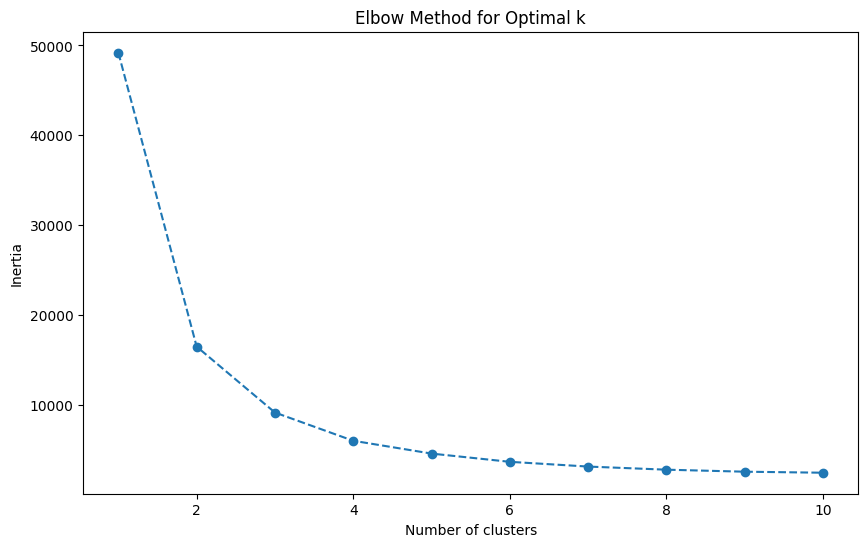

In [5]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Elbow method to find the optimal k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


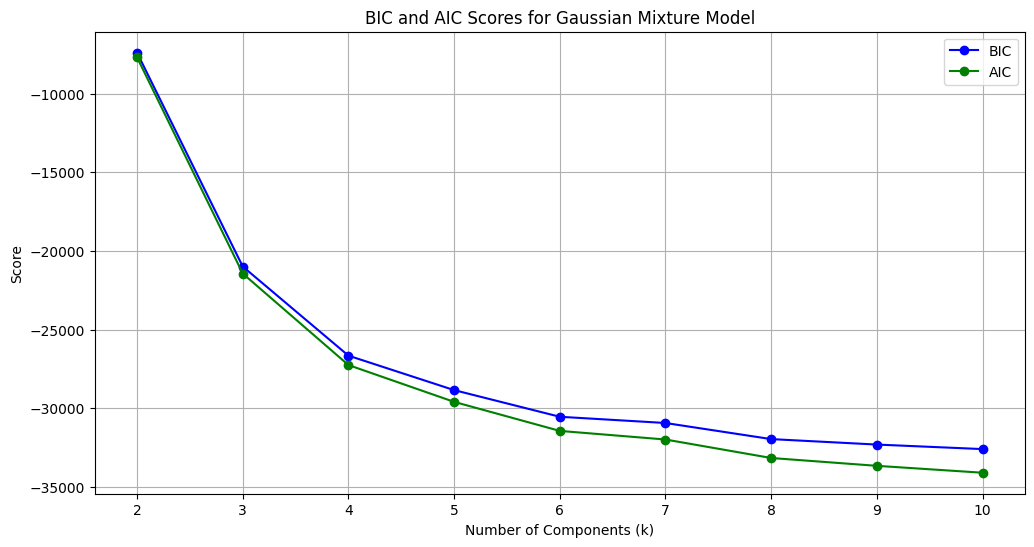

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

# Define the range of components (k) to evaluate
k_range = range(2, 11)  # Evaluate from 2 to 10 components

# Initialize lists to store evaluation metrics
bic_scores = []
aic_scores = []

# Loop through each value of k
for k in k_range:
    # Create a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, random_state=42)
    
    # Fit the model to the scaled data
    gmm.fit(scaled_data)
    
    # Calculate BIC and AIC
    bic = gmm.bic(scaled_data)
    aic = gmm.aic(scaled_data)
    
    # Store BIC and AIC scores
    bic_scores.append(bic)
    aic_scores.append(aic)
    
    # Predict clusters
    cluster_labels = gmm.predict(scaled_data)
    
# Plotting BIC and AIC scores
plt.figure(figsize=(12, 6))
plt.plot(k_range, bic_scores, marker='o', label='BIC', color='blue')
plt.plot(k_range, aic_scores, marker='o', label='AIC', color='green')
plt.xlabel('Number of Components (k)')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for Gaussian Mixture Model')
plt.xticks(k_range)
plt.legend()
plt.grid(True)
plt.show()


## Select k=3 and k_gmm=10

In [7]:
k = 3
k_gmm=10

# Perform k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)
# Add cluster labels to the original dataframe
traffic_data['Cluster'] = kmeans.labels_

# Perform GMM with 3 clusters
gmm = GaussianMixture(n_components=k_gmm, random_state=42)
# Fit the model
gmm.fit(scaled_data)
# Predict the cluster labels
cluster_labels = gmm.predict(scaled_data)
traffic_data['Cluster_GMM'] = cluster_labels

## Create visualizations for the clusters

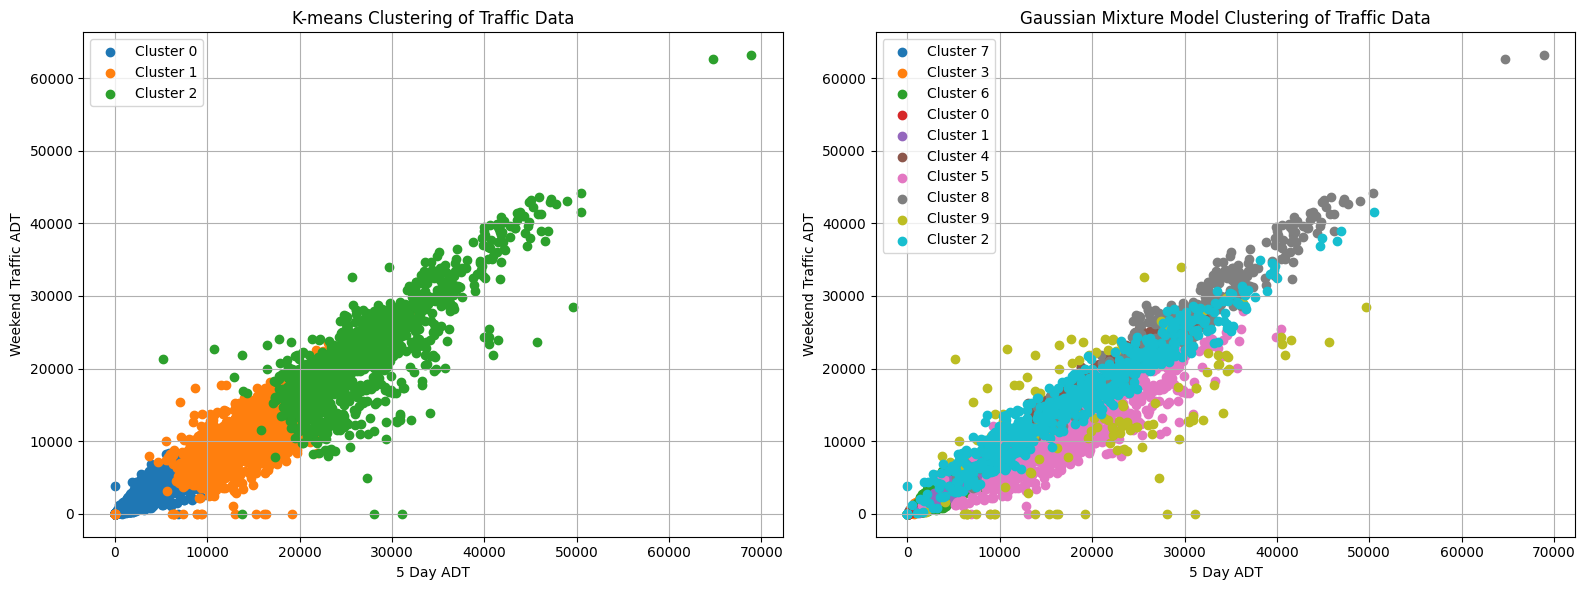

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Scatter plot based on two selected features
plot_columns = ['5 Day ADT', 'Weekend Traffic ADT']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figsize as needed

# Plot for K-means clustering
for cluster in traffic_data['Cluster'].unique():
    cluster_data = traffic_data[traffic_data['Cluster'] == cluster]
    ax1.scatter(cluster_data[plot_columns[0]], cluster_data[plot_columns[1]], label=f'Cluster {cluster}')

ax1.set_title('K-means Clustering of Traffic Data')
ax1.set_xlabel(plot_columns[0])
ax1.set_ylabel(plot_columns[1])
ax1.legend()
ax1.grid(True)

# Plot for Gaussian Mixture Model (GMM) clustering
for cluster in traffic_data['Cluster_GMM'].unique():
    cluster_data = traffic_data[traffic_data['Cluster_GMM'] == cluster]
    ax2.scatter(cluster_data[plot_columns[0]], cluster_data[plot_columns[1]], label=f'Cluster {cluster}')

ax2.set_title('Gaussian Mixture Model Clustering of Traffic Data')
ax2.set_xlabel(plot_columns[0])
ax2.set_ylabel(plot_columns[1])
ax2.legend()
ax2.grid(True)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

plt.show()


## Filter out the outliers to achieve a more polished plot.

In [9]:
import numpy as np
from scipy import stats

# Calculate Z-scores for the selected columns
z_scores = np.abs(stats.zscore(traffic_data[plot_columns]))

# Define a threshold for Z-score
threshold = 2

# Filter rows where any Z-score exceeds the threshold
filtered_data = traffic_data[(z_scores < threshold).all(axis=1)].copy()  # Make a copy to avoid SettingWithCopyWarning

# Now, use filtered_data for K-means clustering
scaled_data = scaler.fit_transform(filtered_data[selected_columns])

# Perform K-means clustering on filtered and scaled data
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)

# Assign cluster labels using .loc to avoid SettingWithCopyWarning
filtered_data.loc[:, 'Cluster'] = kmeans.labels_

# Perform Gaussian Mixture Model (GMM) clustering on filtered and scaled data
gmm = GaussianMixture(n_components=k_gmm, random_state=42)
# Fit the model
gmm.fit(scaled_data)

# Predict the cluster labels
cluster_labels = gmm.predict(scaled_data)
# Assign cluster labels using .loc to avoid SettingWithCopyWarning
filtered_data.loc[:, 'Cluster_GMM'] = cluster_labels

In [10]:
filtered_data.to_csv('traffic_data_exported.csv', index=False)

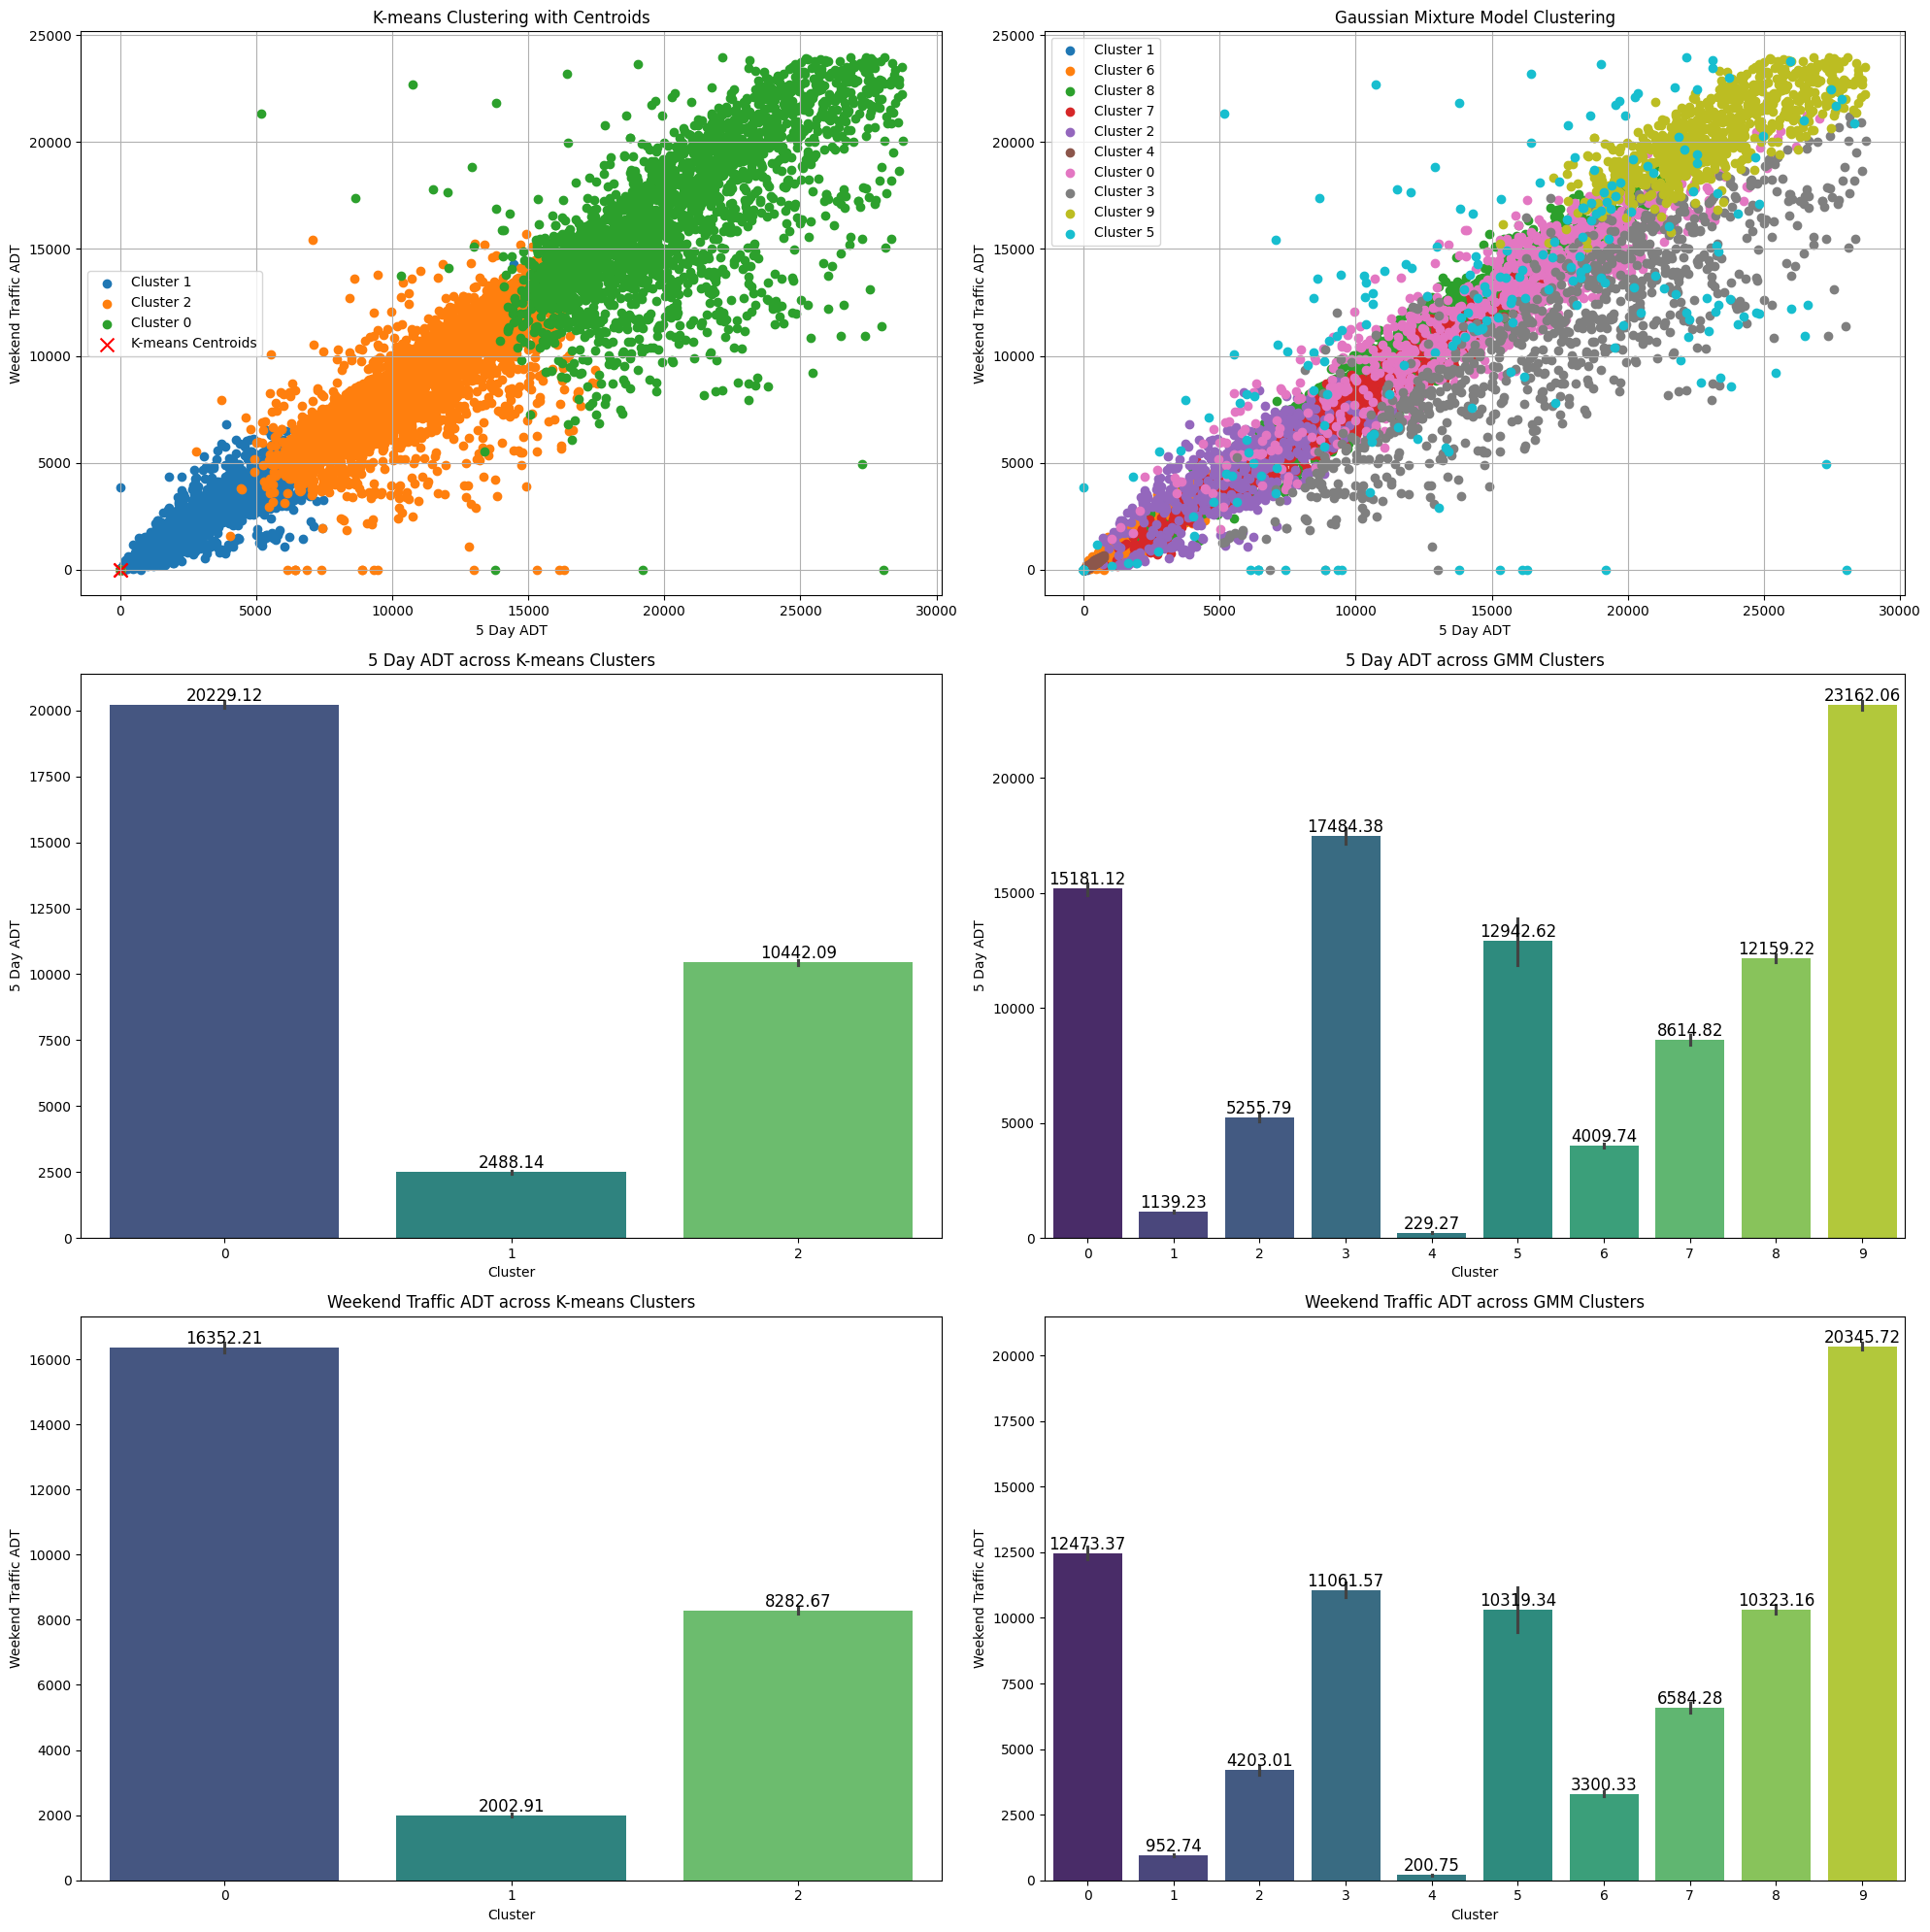

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 20))  # Adjust figsize as needed

for cluster in filtered_data['Cluster'].unique():
    cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
    axes[0, 0].scatter(cluster_data[plot_columns[0]], cluster_data[plot_columns[1]], label=f'Cluster {cluster}')

# Plot centroids
centroids = kmeans.cluster_centers_
axes[0, 0].scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red', s=100, label='K-means Centroids')

axes[0, 0].set_title('K-means Clustering with Centroids')
axes[0, 0].set_xlabel(plot_columns[0])
axes[0, 0].set_ylabel(plot_columns[1])
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot GMM Means

for cluster in filtered_data['Cluster_GMM'].unique():
    cluster_data = filtered_data[filtered_data['Cluster_GMM'] == cluster]
    axes[0, 1].scatter(cluster_data[plot_columns[0]], cluster_data[plot_columns[1]], label=f'Cluster {cluster}')

axes[0, 1].set_title('Gaussian Mixture Model Clustering')
axes[0, 1].set_xlabel(plot_columns[0])
axes[0, 1].set_ylabel(plot_columns[1])
axes[0, 1].legend()
axes[0, 1].grid(True)

# Bar plot for 5 Day ADT across K-means clusters
sns.barplot(x='Cluster', y='5 Day ADT', data=filtered_data, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('5 Day ADT')
axes[1, 0].set_title('5 Day ADT across K-means Clusters')

# Adding labels on top of the bars for K-means
ax = axes[1, 0]
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.2f}'.format(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

# Bar plot for 5 Day ADT across GMM clusters
sns.barplot(x='Cluster_GMM', y='5 Day ADT', data=filtered_data, palette='viridis', ax=axes[1, 1])
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('5 Day ADT')
axes[1, 1].set_title('5 Day ADT across GMM Clusters')

# Adding labels on top of the bars for GMM
ax = axes[1, 1]
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.2f}'.format(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

# Bar plot for Weekend Traffic ADT across K-means clusters
sns.barplot(x='Cluster', y='Weekend Traffic ADT', data=filtered_data, palette='viridis', ax=axes[2, 0])
axes[2, 0].set_xlabel('Cluster')
axes[2, 0].set_ylabel('Weekend Traffic ADT')
axes[2, 0].set_title('Weekend Traffic ADT across K-means Clusters')

# Adding labels on top of the bars for K-means
ax = axes[2, 0]
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.2f}'.format(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

# Bar plot for Weekend Traffic ADT across GMM clusters
sns.barplot(x='Cluster_GMM', y='Weekend Traffic ADT', data=filtered_data, palette='viridis', ax=axes[2, 1])
axes[2, 1].set_xlabel('Cluster')
axes[2, 1].set_ylabel('Weekend Traffic ADT')
axes[2, 1].set_title('Weekend Traffic ADT across GMM Clusters')

# Adding labels on top of the bars for GMM
ax = axes[2, 1]
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.2f}'.format(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

# Adjust layout to prevent overlapping labels
plt.tight_layout()

plt.show()



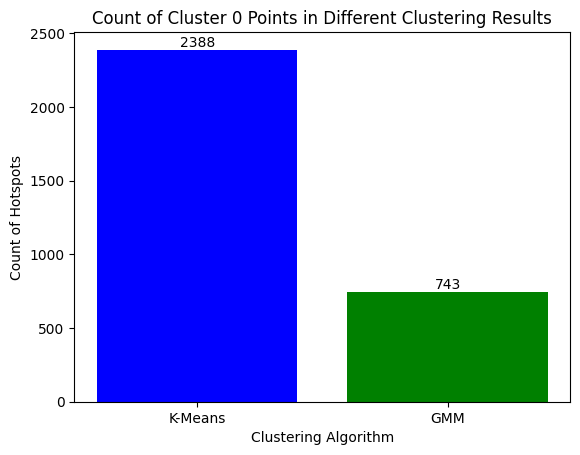

In [12]:
import numpy as np
kmeans_cluster0_count = np.sum(filtered_data['Cluster'] == 0)
clustergmm_cluster0_count = np.sum(filtered_data['Cluster_GMM'] == 9)

# Plotting
labels = ['K-Means', 'GMM']
counts = [kmeans_cluster0_count, clustergmm_cluster0_count]

plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Clustering Algorithm')
plt.ylabel('Count of Hotspots')
plt.title('Count of Cluster 0 Points in Different Clustering Results')
# Adding labels on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


## Generating Folium Map for Hotspot Data

In [13]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

hotspots_cluster = 0

# Filter data to include only points belonging to Cluster 0 for both K-means and GMM
cluster_2_kmeans_data = filtered_data[filtered_data['Cluster'] == hotspots_cluster]
cluster_2_gmm_data = filtered_data[filtered_data['Cluster_GMM'] == hotspots_cluster]

# Initialize Folium map centered around a location of interest
map_center = [filtered_data['Latitude'].mean(), filtered_data['Longitude'].mean()]  # Centered around mean location
mymap = folium.Map(location=map_center, zoom_start=12)

# Define marker colors for K-means and GMM clusters
kmeans_color = 'blue'
gmm_color = 'green'

# Add markers for each point in Cluster 2 for K-means
marker_cluster_kmeans = MarkerCluster().add_to(mymap)
for idx, row in cluster_2_kmeans_data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], 
                  popup=f"(K-means) Hotspot<br>{row['Count Start Date']}<br>Road: {row['Road Name']}",
                  icon=folium.Icon(color=kmeans_color)).add_to(marker_cluster_kmeans)

# Add markers for each point in Cluster 2 for GMM
marker_cluster_gmm = MarkerCluster().add_to(mymap)
for idx, row in cluster_2_gmm_data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], 
                  popup=f"(GMM) Hotspot<br>{row['Count Start Date']}<br>Road: {row['Road Name']}",
                  icon=folium.Icon(color=gmm_color)).add_to(marker_cluster_gmm)

# Save the map to an HTML file (optional)
mymap.save('cluster_2_map.html')

# Display the map
mymap
